# PRL paper: https://journals-aps-org.libaccess.sjlibrary.org/prl/pdf/10.1103/PhysRevLett.126.213601

# Supplemental Material: https://journals-aps-org.libaccess.sjlibrary.org/prl/supplemental/10.1103/PhysRevLett.126.213601/SiVcompare_SM8edits2.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.integrate as spint
font = {'family': 'sans serif',
        'color':  'w',
        'weight': 'normal',
        'size': 8,
        }

# parameters

## caption of FIG. S9

# $ \sigma = 0.2 \, \omega_{10}^{(unstrained)} \newline \gamma_{10} = 0.05 \, \sigma $

# $ \gamma_{10} = \frac{1}{2} \left( \Gamma_{10} + \Gamma_{12} \right) + \gamma_c \, \, \, \, \, \, \text{with} \, \, \, \, \, \, \gamma_c \gg \frac{1}{2} \left( \Gamma_{10} + \Gamma_{12} \right) \tag{s7}$

In [2]:
hbar = 1.
mu = 1.
N = 1.
omega12 = 1.
omega10_unstrained1 = 1.2 * np.pi
omega10_unstrained2 = 2.8 * np.pi

sigma1 = 0.2 * omega10_unstrained1
sigma2 = 0.2 * omega10_unstrained2
gamma10 = 0.05 * np.mean([sigma1,sigma2])
Gamma10 = gamma10 * 1E-5

# colorbar function

In [3]:
# @numba.jit
def colorbar(mappable, label=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label, **font)
    plt.yticks(**font)
    plt.tick_params(color=font['color'])
    plt.sca(last_axes)
    ax.tick_params(color=font['color'])
    return cbar

In [36]:
# @numba.jit
def slices_plots(
        databox,
        titles=None,
        figure_shape=[4, 4],
        figure_size=(10, 10),
        vertical_gap=0.15,
        horizontal_gap=0.15,
        shared_x_label=r'$\omega_t \quad [2 \pi] $',
        shared_x_label_x_position=0.5,
        shared_x_label_y_position=0.08,
        shared_y_label=r'$\omega_\tau \quad [2 \pi] $',
        shared_y_label_x_position=0.08,
        shared_y_label_y_postion=0.5,
        shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) \right\}$',
        shared_title_x_position=0.5,
        shared_title_y_position=0.94,
        share_x_axis=True,
        share_y_axis=True,
        colorbar_label='Amplitude (arb. units)',
        dpi=300):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        dpi=dpi,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            "hspace": vertical_gap,
            'wspace': horizontal_gap
        })

    if titles is None:
        titles = [r'$\omega_{10} =$' f'{i / np.pi:.2f} $\pi$' for i in omega_10_vals]

    for i in range(np.shape(databox)[0]):
        im = ax.flatten()[i].imshow(
            databox[i].T,
            origin='lower',
            extent=(min(omega_t / 2. / np.pi ), max(omega_t / 2. / np.pi ), min(omega_tau / 2. / np.pi ), max(omega_tau / 2. / np.pi ))
        )
        ax.flatten()[i].set_title(titles[i], **font)
        ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), font)
        ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), font)
            
        colorbar(im)

    fig.suptitle(x=shared_title_x_position,
                 y=shared_title_y_position,
                 t=shared_title,
                 ha='center',
                 **font)

    if shared_x_label != None:  # shared x label
        fig.text(x=shared_x_label_x_position,
                 y=shared_x_label_y_position,
                 s=shared_x_label,
                 ha='center',
                 **font)

    if shared_y_label != None:  # shared y label
        fig.text(x=shared_y_label_x_position,
                 y=shared_y_label_y_postion,
                 s=shared_y_label,
                 va='center',
                 rotation='vertical',
                 **font)

    plt.show()

 # complex square function

In [5]:
@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2

# creating mesh

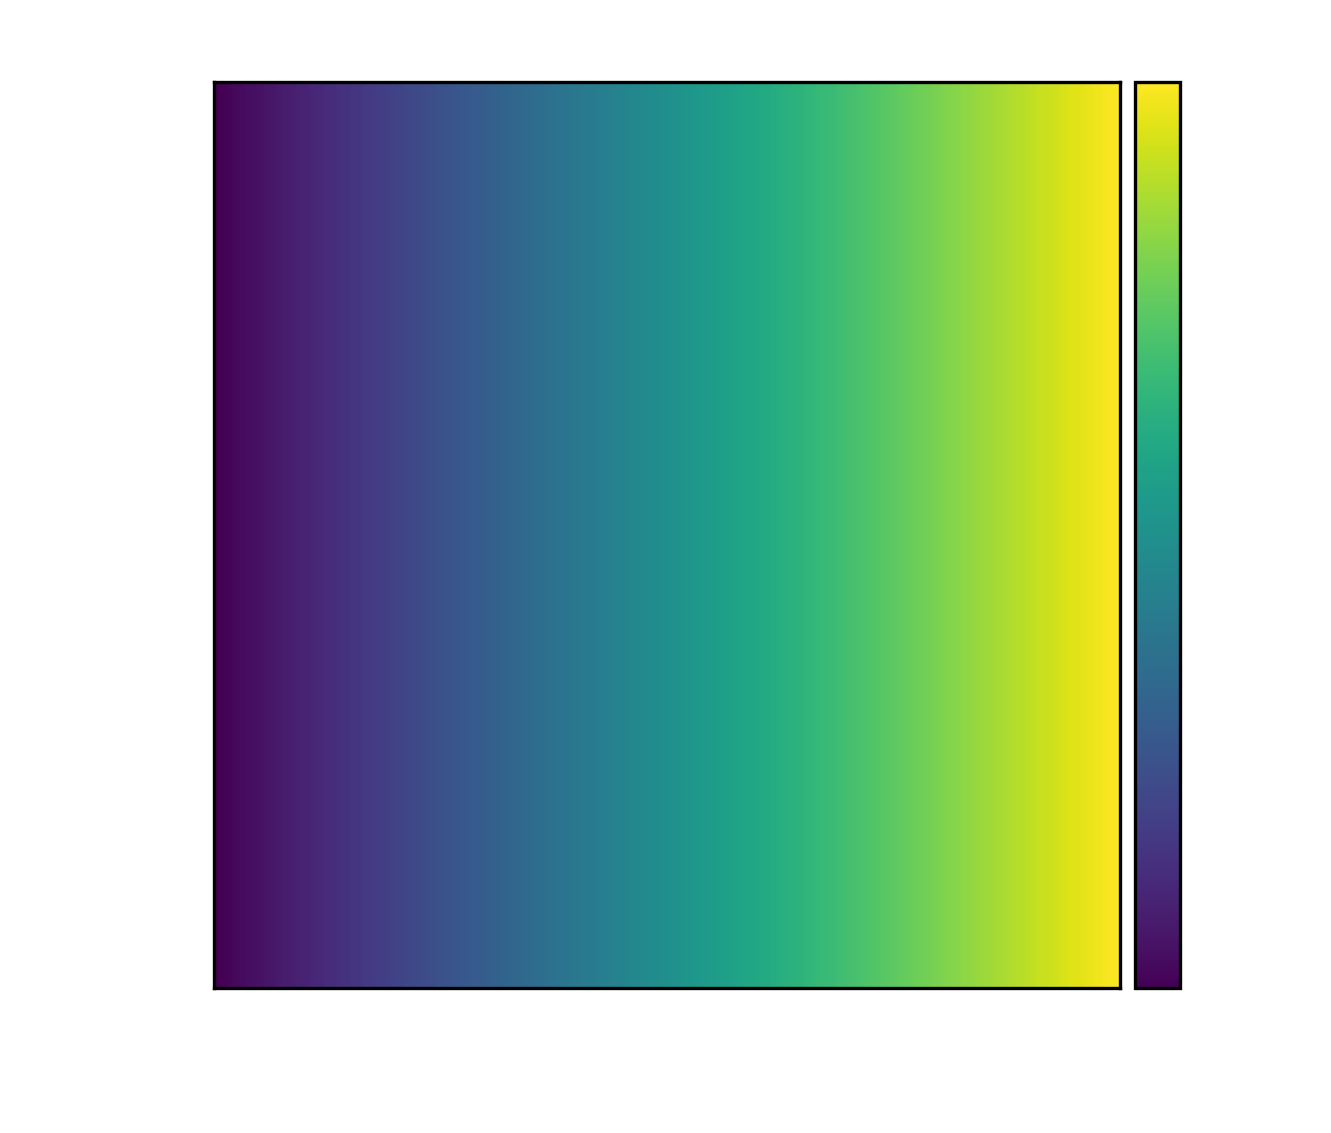

In [6]:
omega_t = np.linspace(0., 4.*np.pi, 200)
omega_tau = np.linspace(-4.*np.pi, 0., 200)
omega_t_mesh, omega_tau_mesh = np.meshgrid(omega_t, omega_tau, indexing='xy')
plt.figure(dpi=300)
im = plt.imshow(omega_t_mesh, origin='lower', extent=(min(omega_t / 2. / np.pi ), max(omega_t / 2. / np.pi ), min(omega_tau / 2. / np.pi ), max(omega_tau / 2. / np.pi )))
plt.xlabel(r'$\omega_t \quad [2 \pi] $', fontdict=font)
plt.ylabel(r'$\omega_\tau \quad [2 \pi] $', fontdict=font)
plt.title(r'$\omega_t$ mesh', fontdict=font)
plt.xticks(**font)
plt.yticks(**font)
colorbar(im, 'Amplitude')
plt.show()

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/814950612.py:45: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), font)
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/814950612.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), font)
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/814950612.py:46: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), font)
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/814950612.py:46:

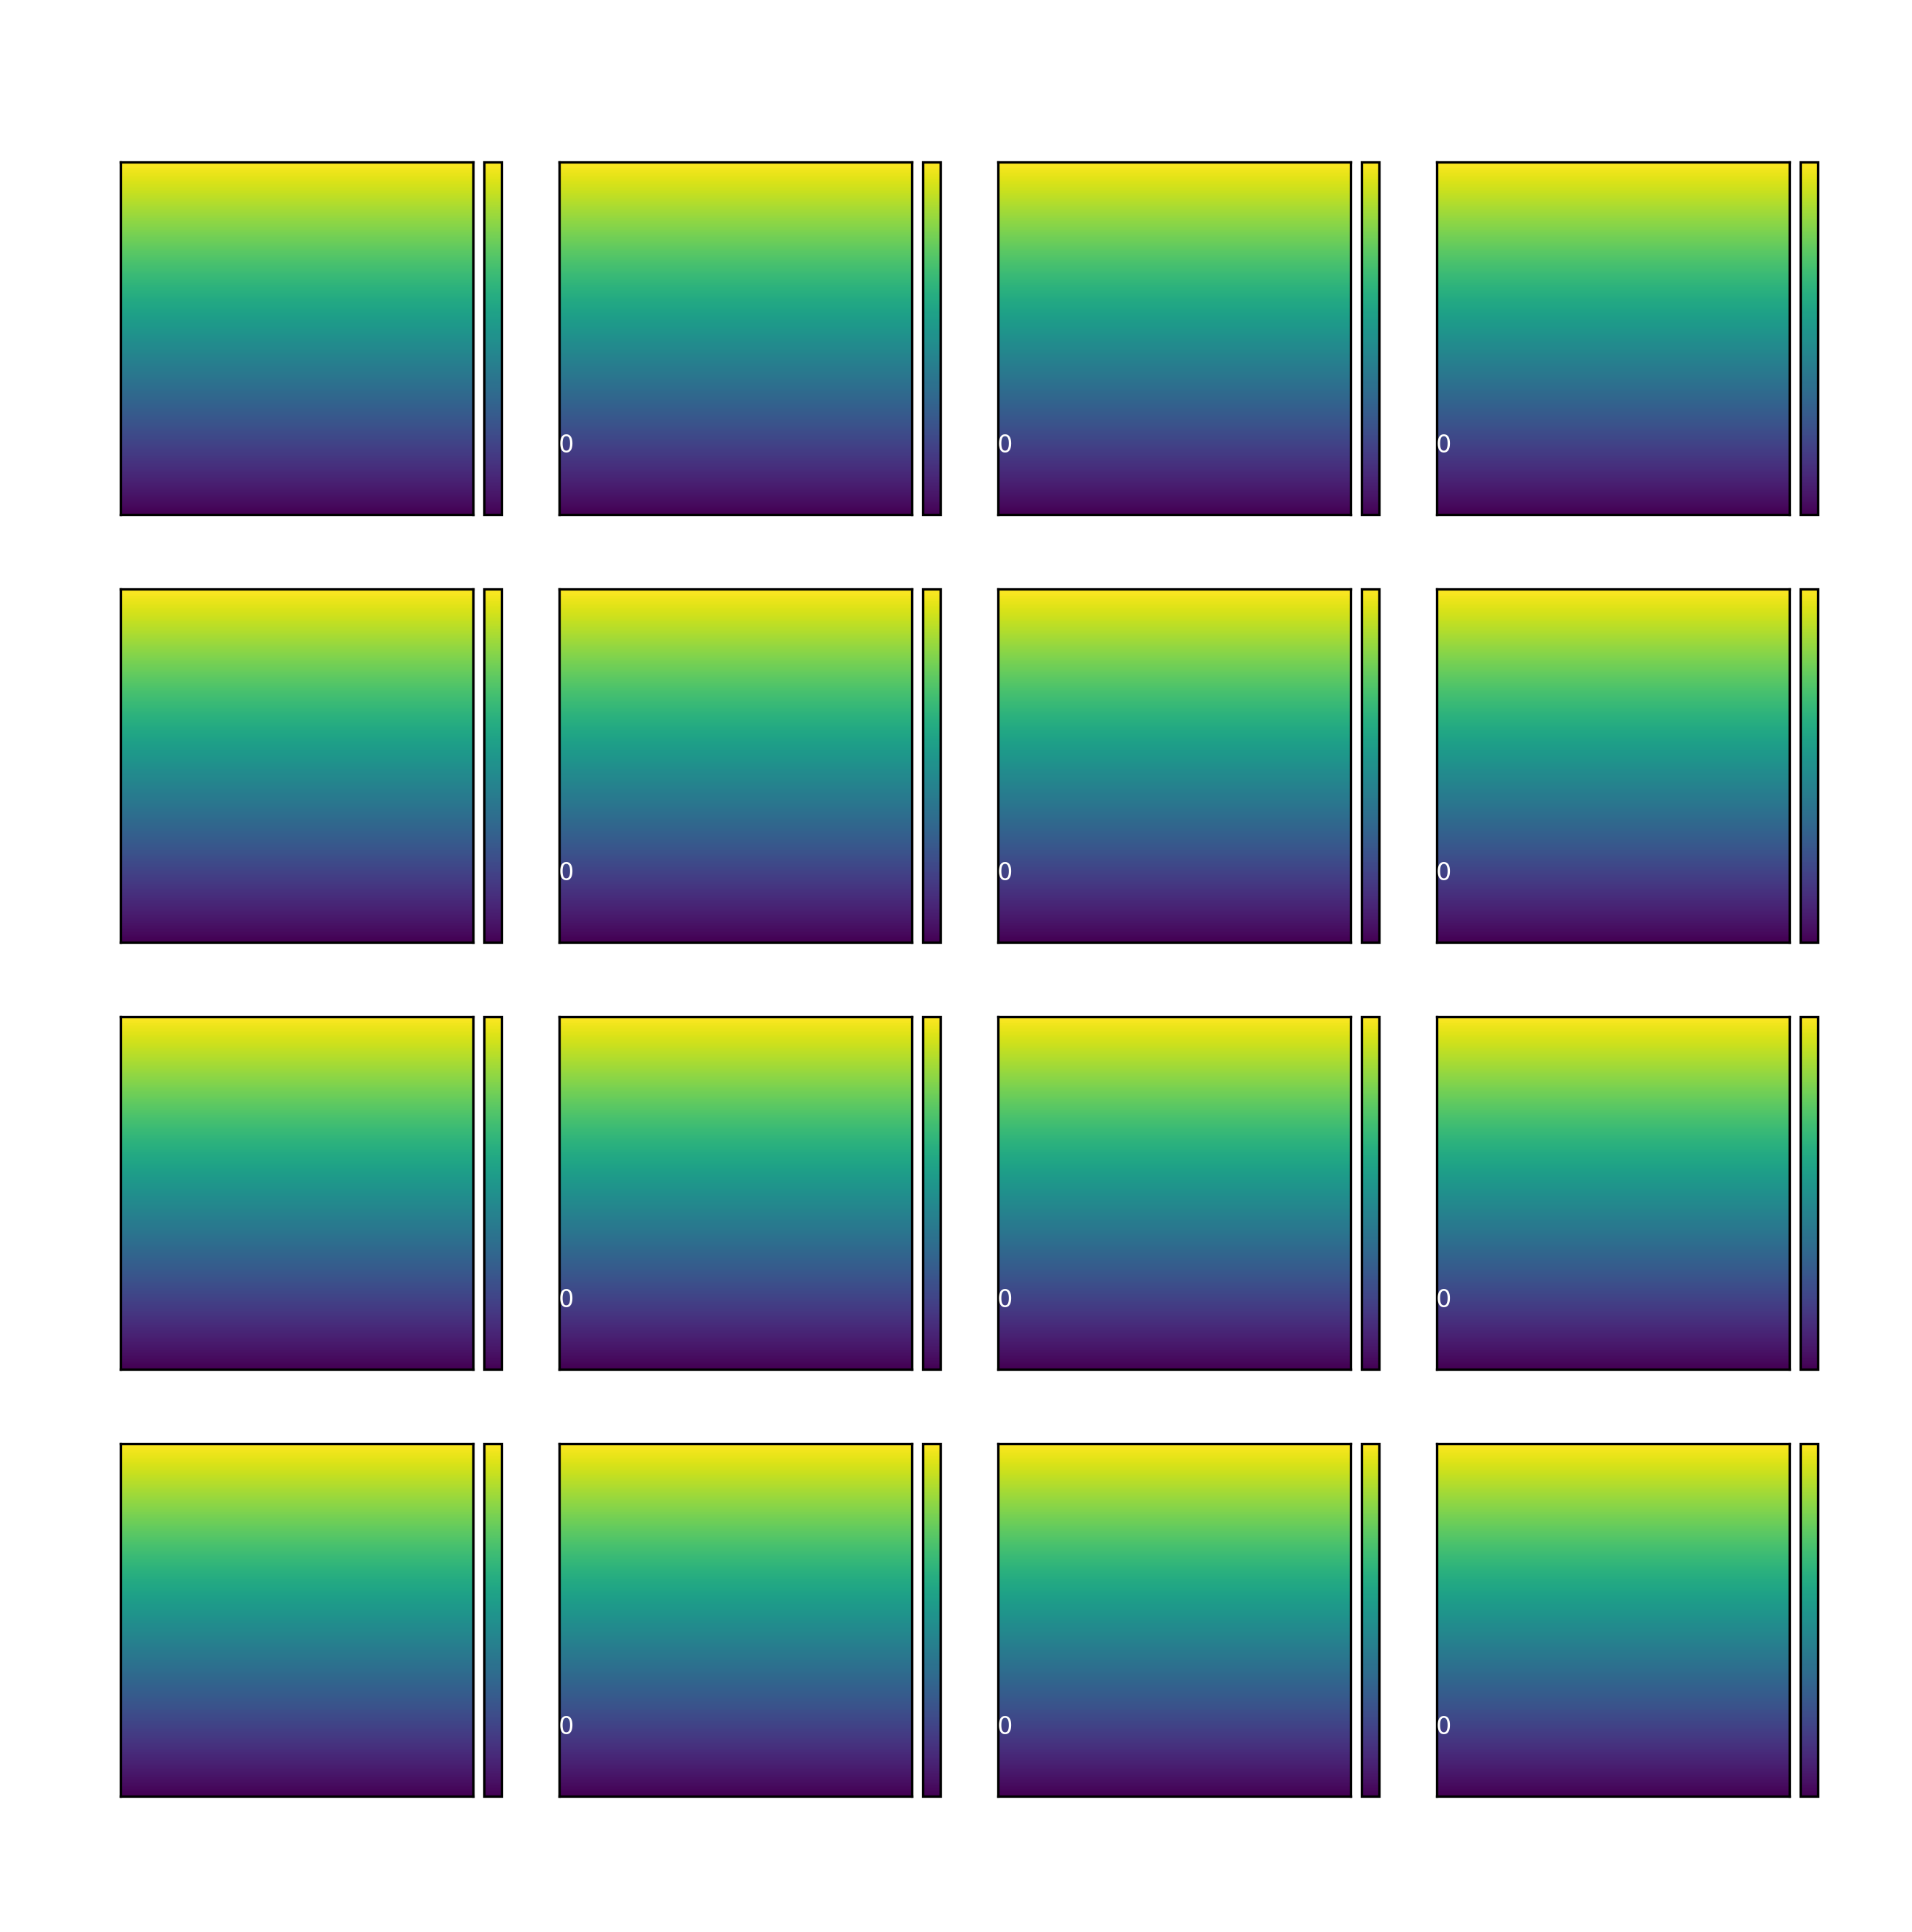

In [37]:
omega_10_vals = np.linspace(0. , 4. * np.pi, 16)
omega_10_3Dmesh, omega_t_3Dmesh, omega_tau_3Dmesh = np.meshgrid(omega_10_vals, omega_t, omega_tau, indexing='ij')

slices_plots(omega_tau_3Dmesh)

# Why is the x-axis changing??? Why 0 - 1? not 0 - 2

In [8]:
np.shape(omega_t_3Dmesh[:].T)

(200, 200, 16)

# density matrix element

## index 10, 3rd order correction

# $ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) = -\frac{\mathcal{i} |\mu|^2 \mu }{8 \hbar^3} \left( \frac{i}{\omega_t - \left[ \omega_{10} - \mathcal{i} \gamma_{10} \right] } \right) \left( \frac{\mathcal{i}}{\omega_\tau - \left[ -\omega_{10} - i \gamma_{10} \right] } \right) \tag{s11} $

In [38]:
@numba.jit
def rho_10_sig_3(omega_t, omega_tau, omega10):
    return -1j * abs2(mu) * mu / 8. / hbar**3. * (1j / (omega_t - (omega10 - 1j*gamma10))) * (1j / (omega_tau - (-omega10 - 1j*gamma10)))

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/814950612.py:45: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), font)
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/814950612.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), font)
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/814950612.py:46: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), font)
/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/814950612.py:46:

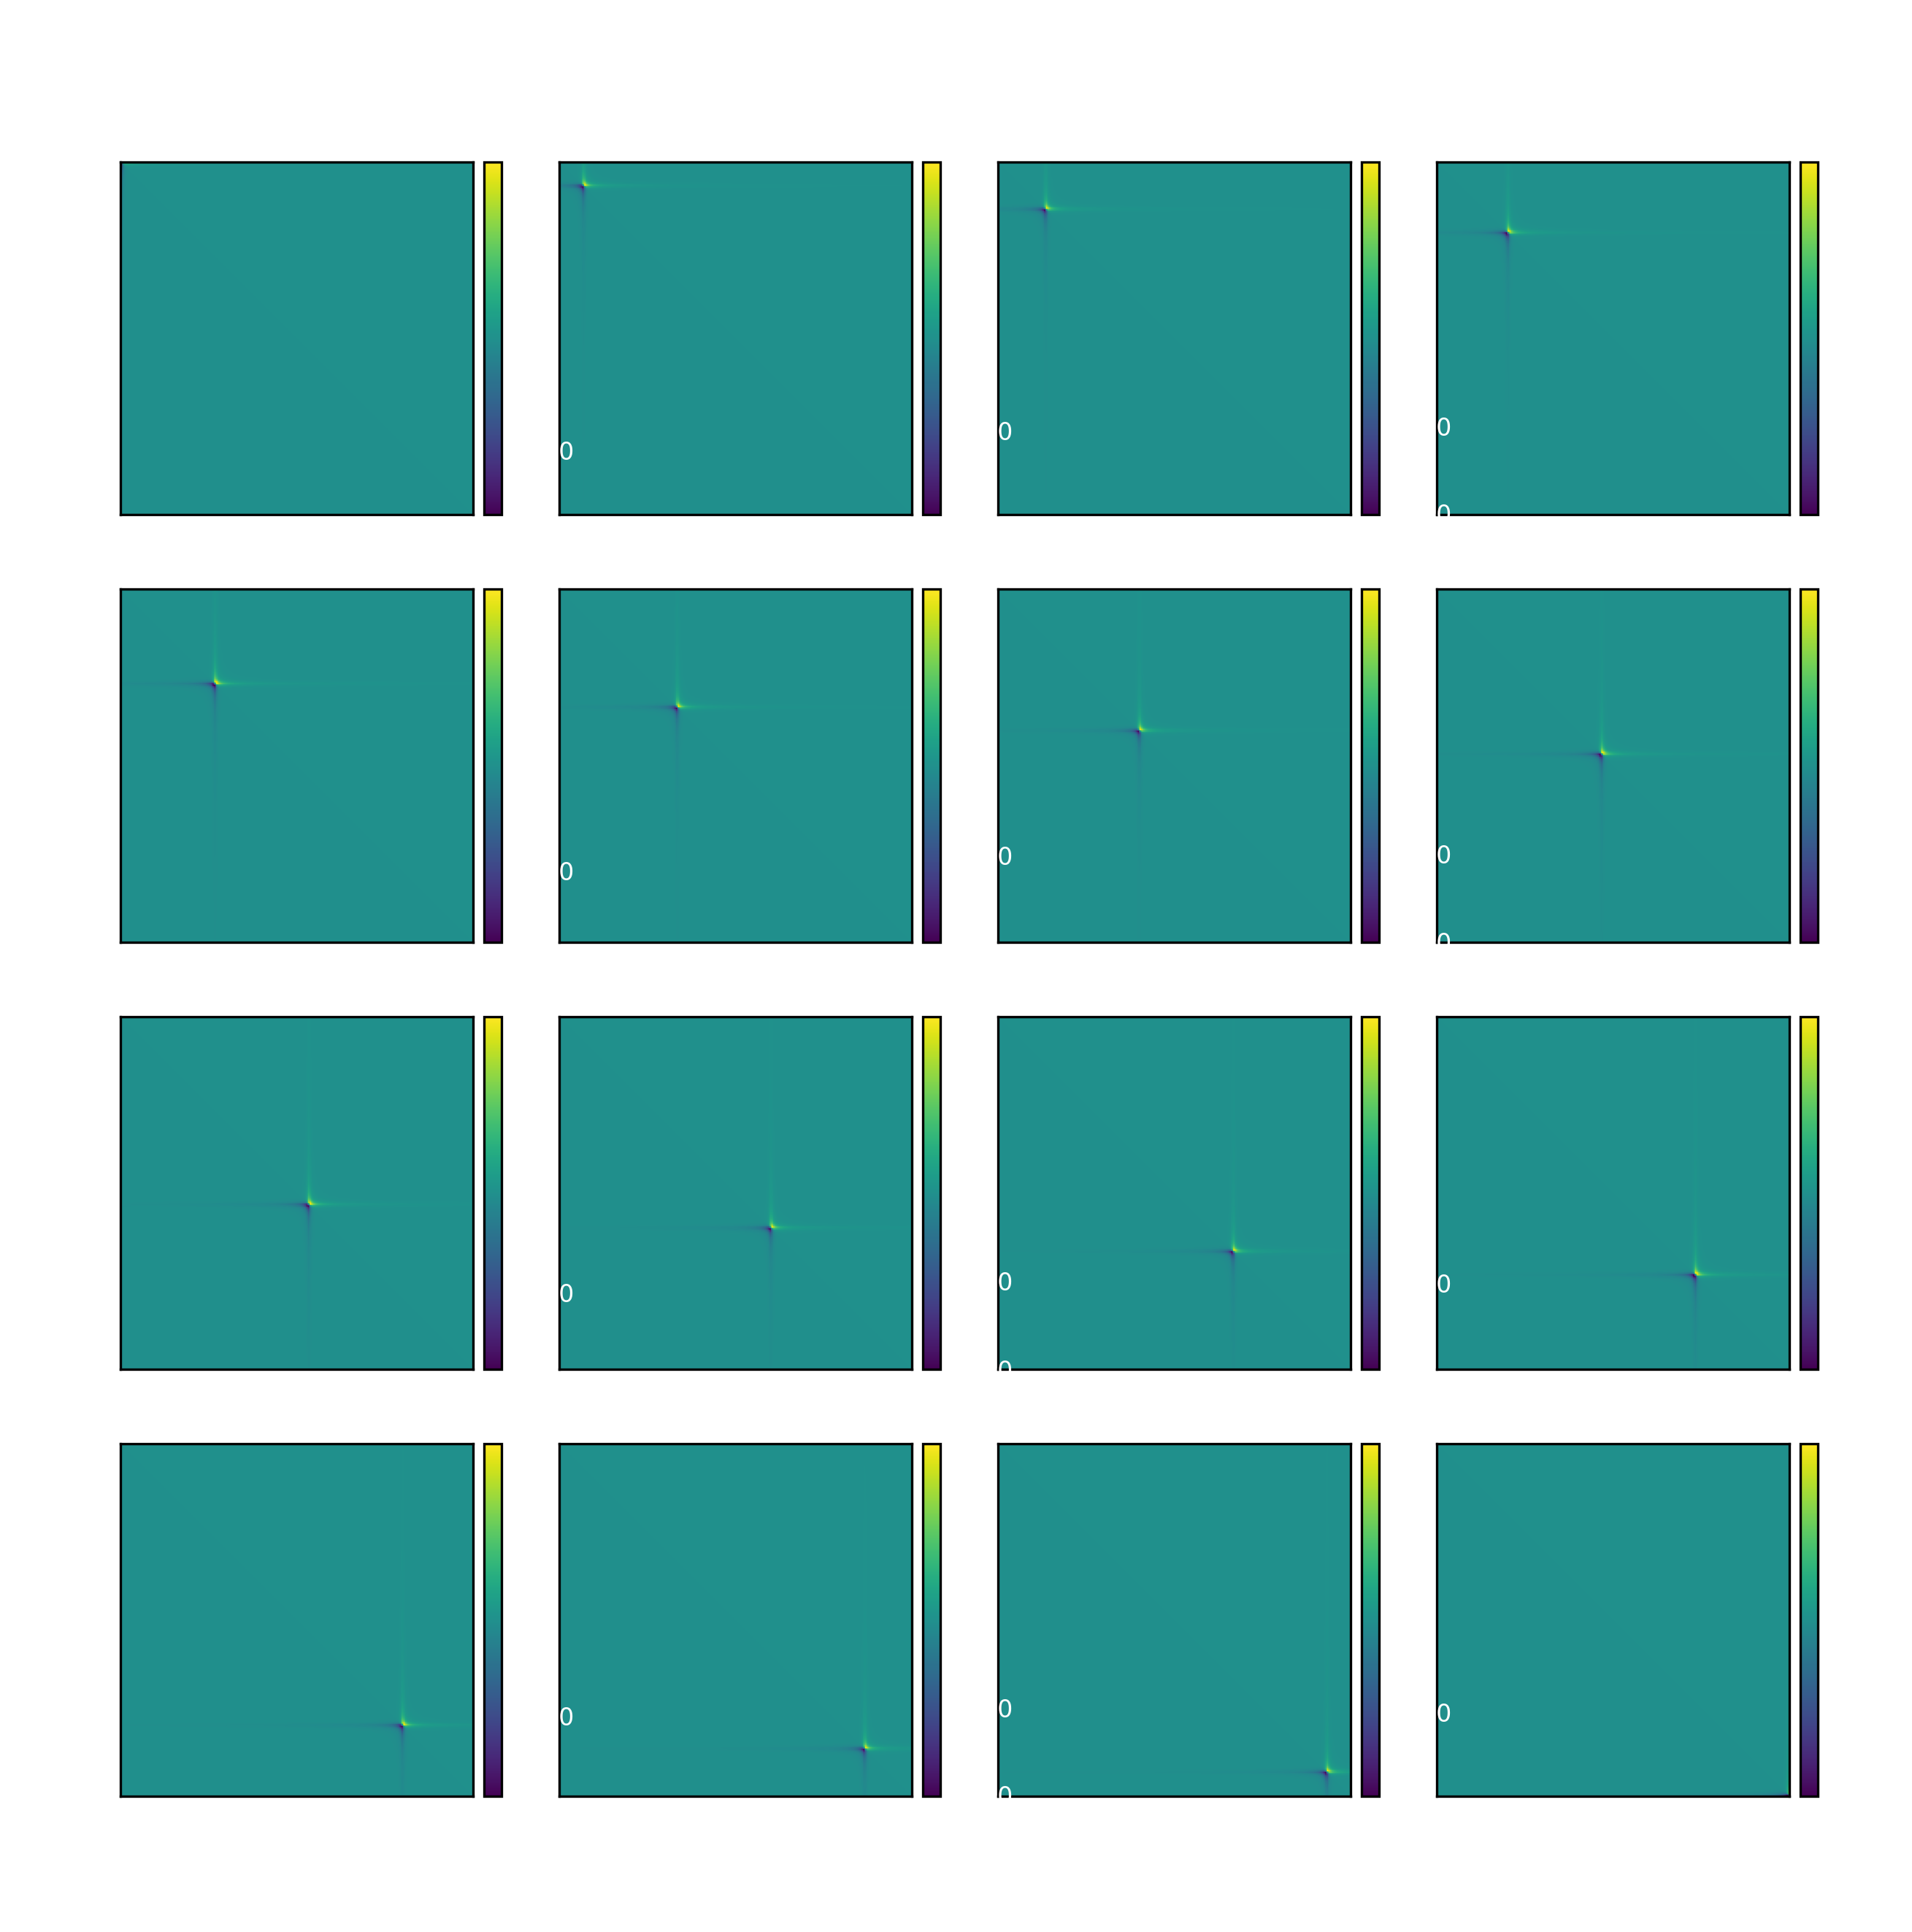

In [39]:
slices_plots(rho_10_sig_3(omega_t_3Dmesh, omega_tau_3Dmesh, omega_10_3Dmesh).real)

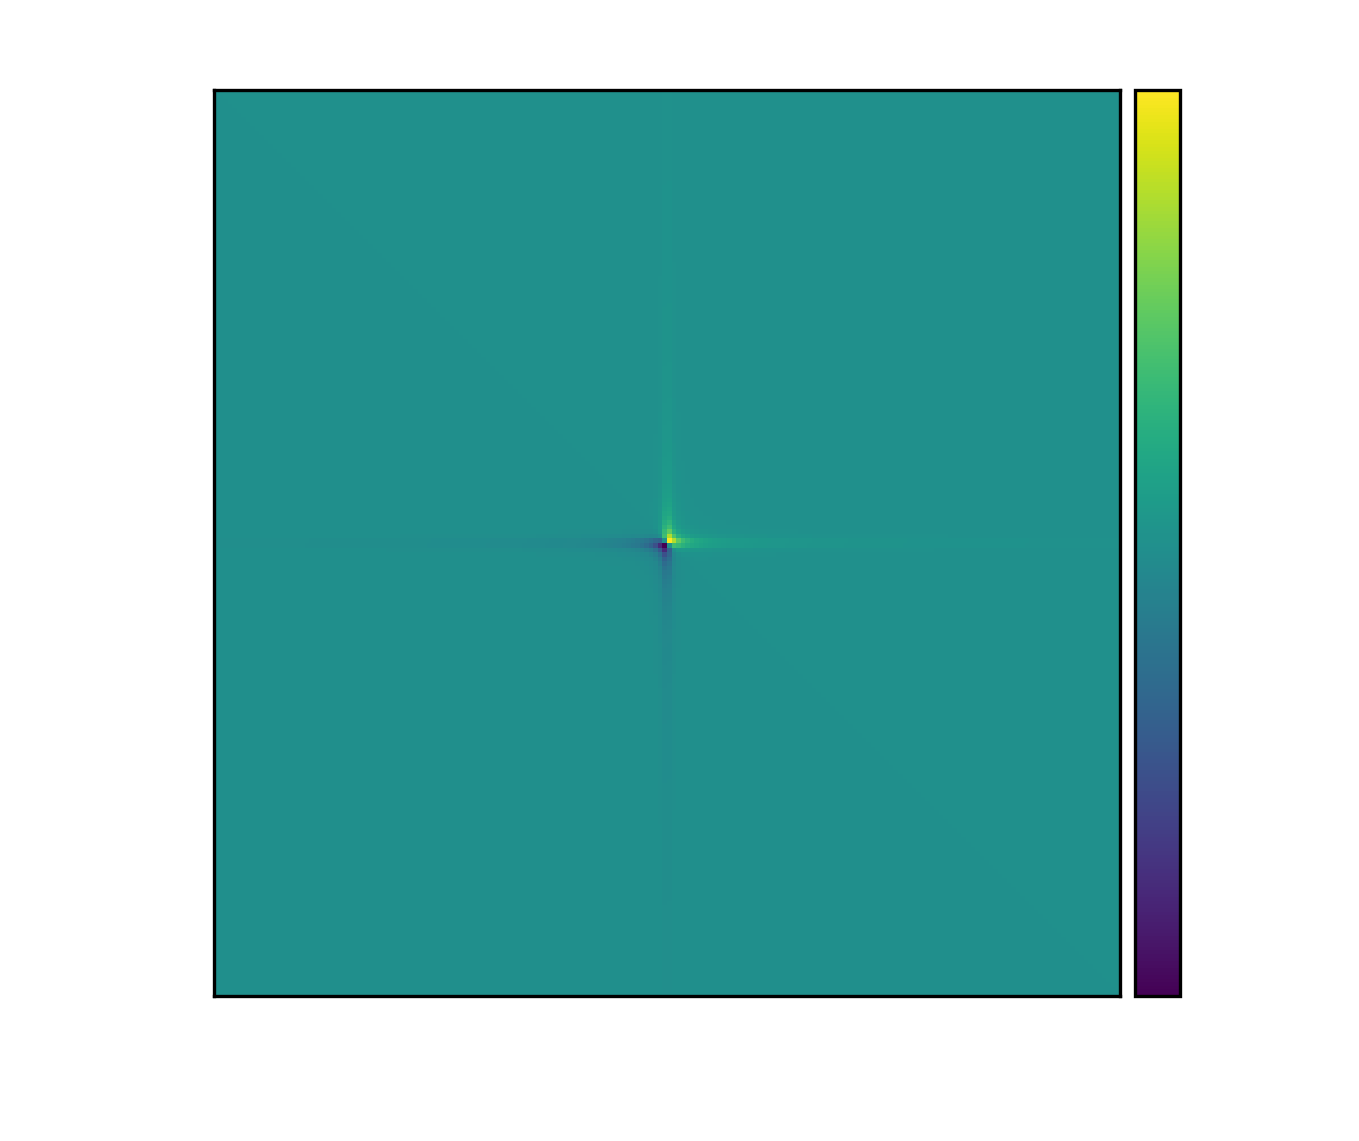

In [11]:
omega_10 = 2*np.pi

fig = plt.figure(dpi=300)
im = plt.imshow(rho_10_sig_3(omega_t_mesh, omega_tau_mesh, omega_10).real, origin='lower', extent=(min(omega_t / 2. / np.pi ), max(omega_t / 2. / np.pi ), min(omega_tau / 2. / np.pi ), max(omega_tau / 2. / np.pi )))
plt.xlabel(r'$\omega_t \quad [2 \pi] $', fontdict=font)
plt.ylabel(r'$\omega_\tau \quad [2 \pi] $', fontdict=font)
plt.xticks(**font)
plt.yticks(**font)
plt.title(r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) \right\}, \qquad \omega_{10} =$' f'{omega_10 / np.pi:.2f} $\pi$', fontdict=font)
colorbar(im, 'Amplitude (arb. units)')
plt.show()

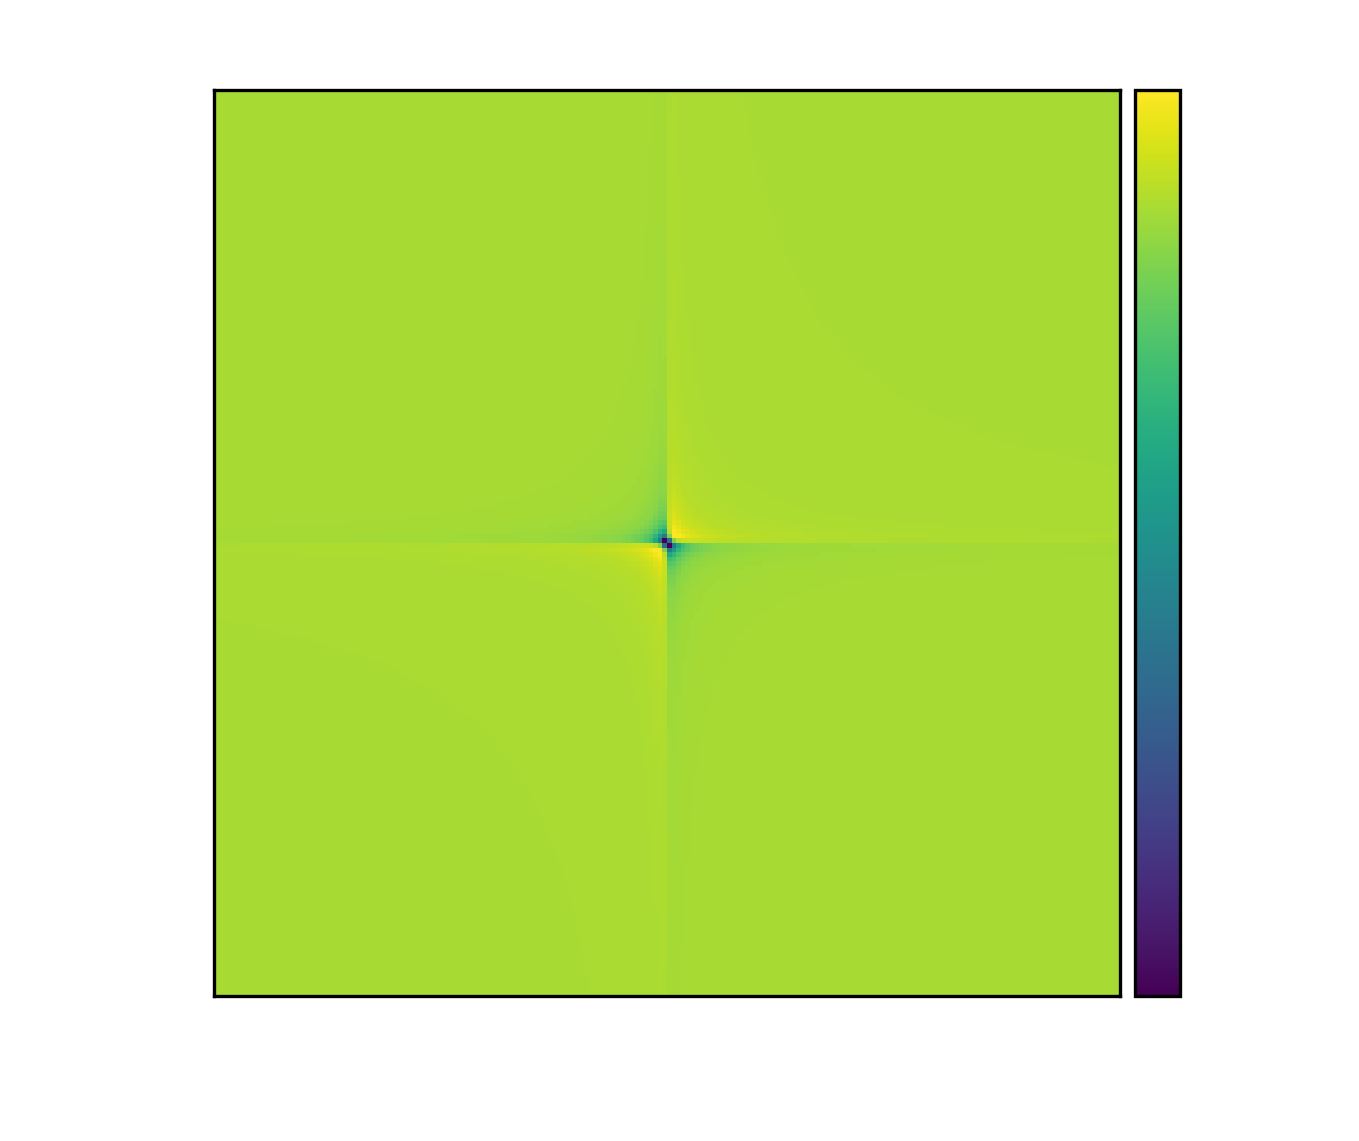

In [12]:
fig = plt.figure(dpi=300)
im = plt.imshow(rho_10_sig_3(omega_t_mesh, omega_tau_mesh, omega_10).imag, origin='lower', extent=(min(omega_t / 2. / np.pi ), max(omega_t / 2. / np.pi ), min(omega_tau / 2. / np.pi ), max(omega_tau / 2. / np.pi )))
plt.xlabel(r'$\omega_t \quad [2 \pi] $', fontdict=font)
plt.ylabel(r'$\omega_\tau \quad [2 \pi] $', fontdict=font)
plt.xticks(**font)
plt.yticks(**font)
plt.title(r'$\mathfrak{I} \left\{ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) \right\}, \qquad \omega_{10} =$' f'{omega_10 / np.pi:.2f} $\pi$', fontdict=font)
colorbar(im, 'Amplitude (arb. units)')
plt.show()

## index 11, 4th order correction

# $ \rho^{(4)}_{11,sig} (\omega_t, \omega_\tau) = \frac{|\mu|^4}{16 \hbar^4} \left( \frac{i}{\omega_t - \left[ \omega_{10} - i \gamma_{10} \right] } \right) \left( \frac{i}{\omega_\tau - \left[ -\omega_{10} - i \gamma_{10} \right] } \right) \tag{s15} $

In [13]:
@numba.jit
def rho_11_sig_4(omega_t, omega_tau, omega10):
    return abs2(mu)**2. / 16. / hbar**4. * (1j / (omega_t - (omega10 - 1j*gamma10))) * (1j / (omega_tau - (-omega10 - 1j*gamma10)))

# electron-phonon coupling function

## equation is written in text at the very beginning of p. 15 of the Supplementary Material

# $ R (\omega_{10}, \, \omega_{12}) = R (\omega_{12}) \propto \omega_{12}^2$

In [14]:
@numba.jit
def R(omega10, omega12):
    return omega12**2.

# $\tilde{E}^*_{LO}$ is the electric field?

# branching ratio

# $B(\omega_{10}, \omega_{12}) = \frac{\Gamma_{10}}{\Gamma_{10} \, + \, \Gamma_{12} (\omega_{10}, \, \omega_{12})} \approx \frac{\Gamma_{10}}{\Gamma_{10} \, + \, R (\omega_{10}, \, \omega_{12})} \tag{s16} $

In [15]:
@numba.jit
def B(omega10, omega12):
    return Gamma10 / (Gamma10 + R(omega10, omega12))

# Gaussian

# $ G \left (\omega_{10} - \omega_{10}^{(unstrained)} \right ) \equiv \frac{N}{\sigma \sqrt{2 \pi}} exp \left[ \frac{-\left (\omega_{10} - \omega_{10}^{(unstrained)} \right )^2}{2 \sigma^2} \right] \tag{s19} $

In [16]:
@numba.jit
def G(omega10):
    return N / sigma1 / np.sqrt(2. * np.pi) * np.exp(-(omega10 - omega10_unstrained1)**2. / 2. / sigma1**2.) + N / sigma2 / np.sqrt(2. * np.pi) * np.exp(-(omega10 - omega10_unstrained2)**2. / 2. / sigma2**2.)

# Infinite integral

In [17]:
@numba.jit
def infint(argu):
    return spint.quad_vec(argu, -np.inf, np.inf)

# converting to angular frequency

omega_t_mesh = 2. * np.pi * nu_t_mesh
omega_tau_mesh = 2. * np.pi * nu_tau_mesh

# computing the integral using https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad_vec.html

# $I_{tot, het}(\omega_t, \omega_\tau) \propto \tilde{E}^*_{LO} (-\omega_t) \displaystyle \int^{\infty}_{-\infty} G \left (\omega_{10} - \omega_{10}^{(unstrained)} \right ) \left [ i \mu^* \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau, \omega_{10}) \right ] d \omega_{10} $ $\tag{s20}$

In [18]:
argu = lambda omega10: G(omega10) * 1j * np.conj(mu) * rho_10_sig_3(omega_t_mesh, omega_tau_mesh, omega10)
I_tot_het, int_err_het = infint(argu)

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/3005950524.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "infint" failed type inference due to: non-precise type pyobject
During: typing of argument at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/3005950524.py (3)

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/3005950524.py", line 3:
<source missing, REPL/exec in use?>

  @numba.jit
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "infint" was compiled in object mode without forceobj=True.

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4687/3005950524.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDep

# $I_{tot, PL}(\omega_t, \omega_\tau) \propto \displaystyle \int^{\infty}_{-\infty} G \left (\omega_{10} - \omega_{10}^{(unstrained)} \right ) B(\omega_{10}, \omega_{12}) \, \rho^{(4)}_{11,sig} (\omega_t, \omega_\tau, \omega_{10}) d \omega_{10} $ $\tag{s21}$

In [19]:
argu = lambda omega10: G(omega10) * B(omega10, omega12) * rho_11_sig_4(omega_t_mesh, omega_tau_mesh, omega10)
I_tot_PL, int_err_PL = infint(argu)

# Plotting Heterodyne detection vs. PL detection simulation results

## Fig. S9(a)

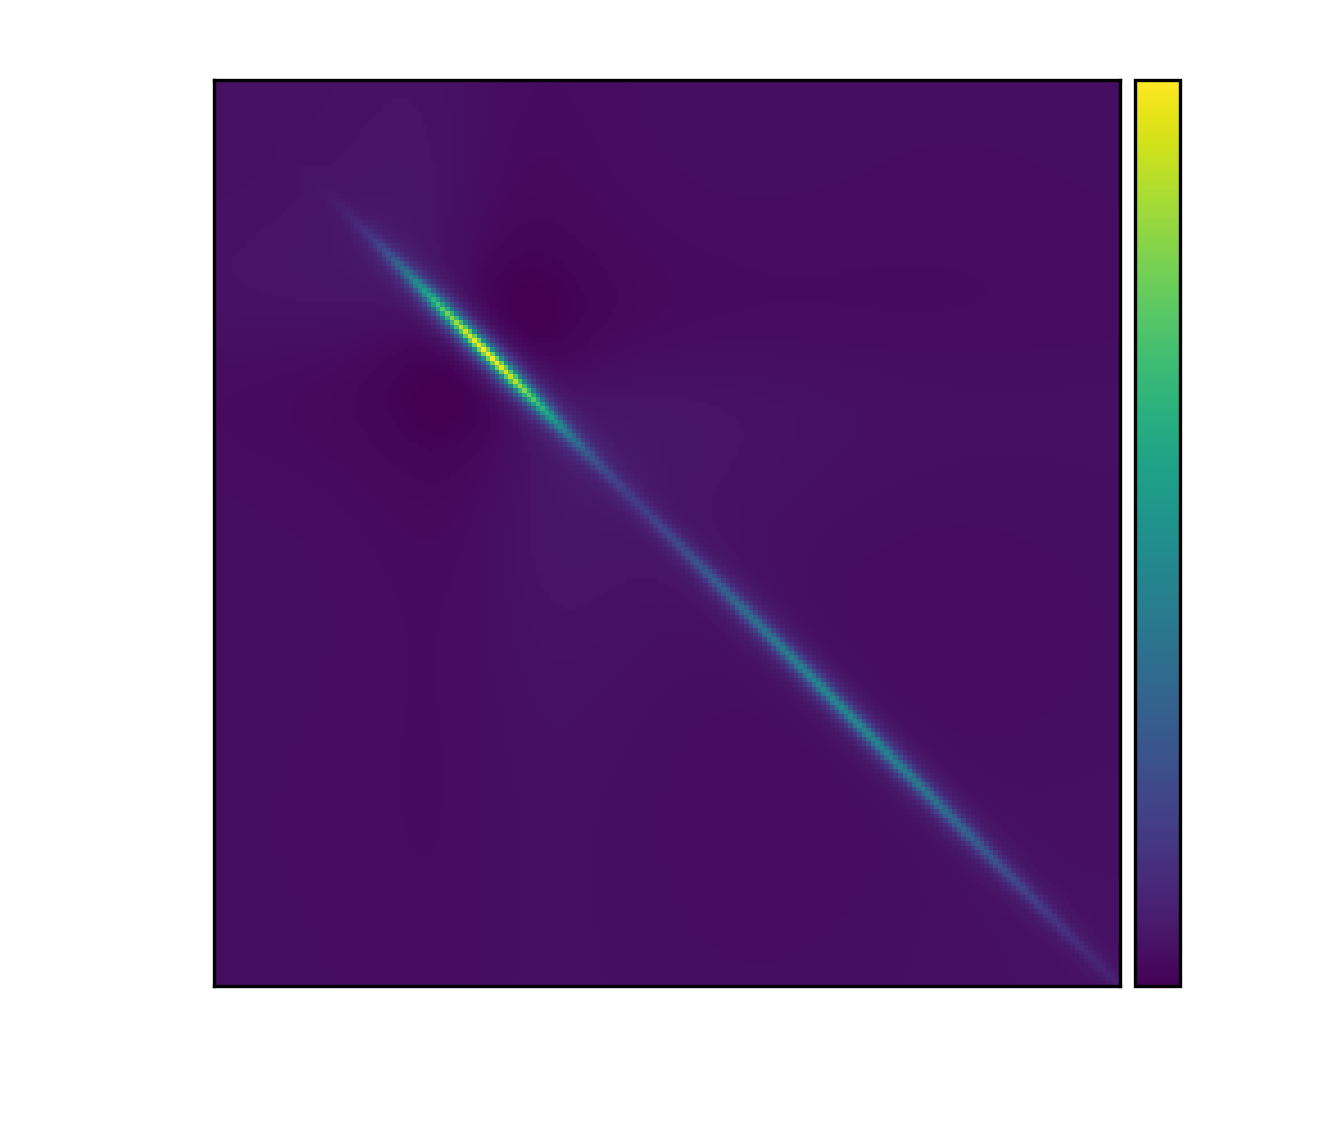

In [20]:
fig = plt.figure(dpi=300)
im = plt.imshow(I_tot_het.real, origin='lower', extent=(min(omega_t / 2. / np.pi ), max(omega_t / 2. / np.pi ), min(omega_tau / 2. / np.pi ), max(omega_tau / 2. / np.pi )))
plt.xlabel(r'$\omega_t \quad [2 \pi] $', fontdict=font)
plt.ylabel(r'$\omega_\tau \quad [2 \pi] $', fontdict=font)
plt.xticks(**font)
plt.yticks(**font)
plt.title('Heterodyne detection sim.', fontdict=font)
colorbar(im, 'Amplitude (arb. units)')
plt.show()
# fig.savefig("/Users/tommychin/Documents/research/Smallwood_research/testVectorImage.eps", dpi=800, format='eps', bbox_inches='tight')

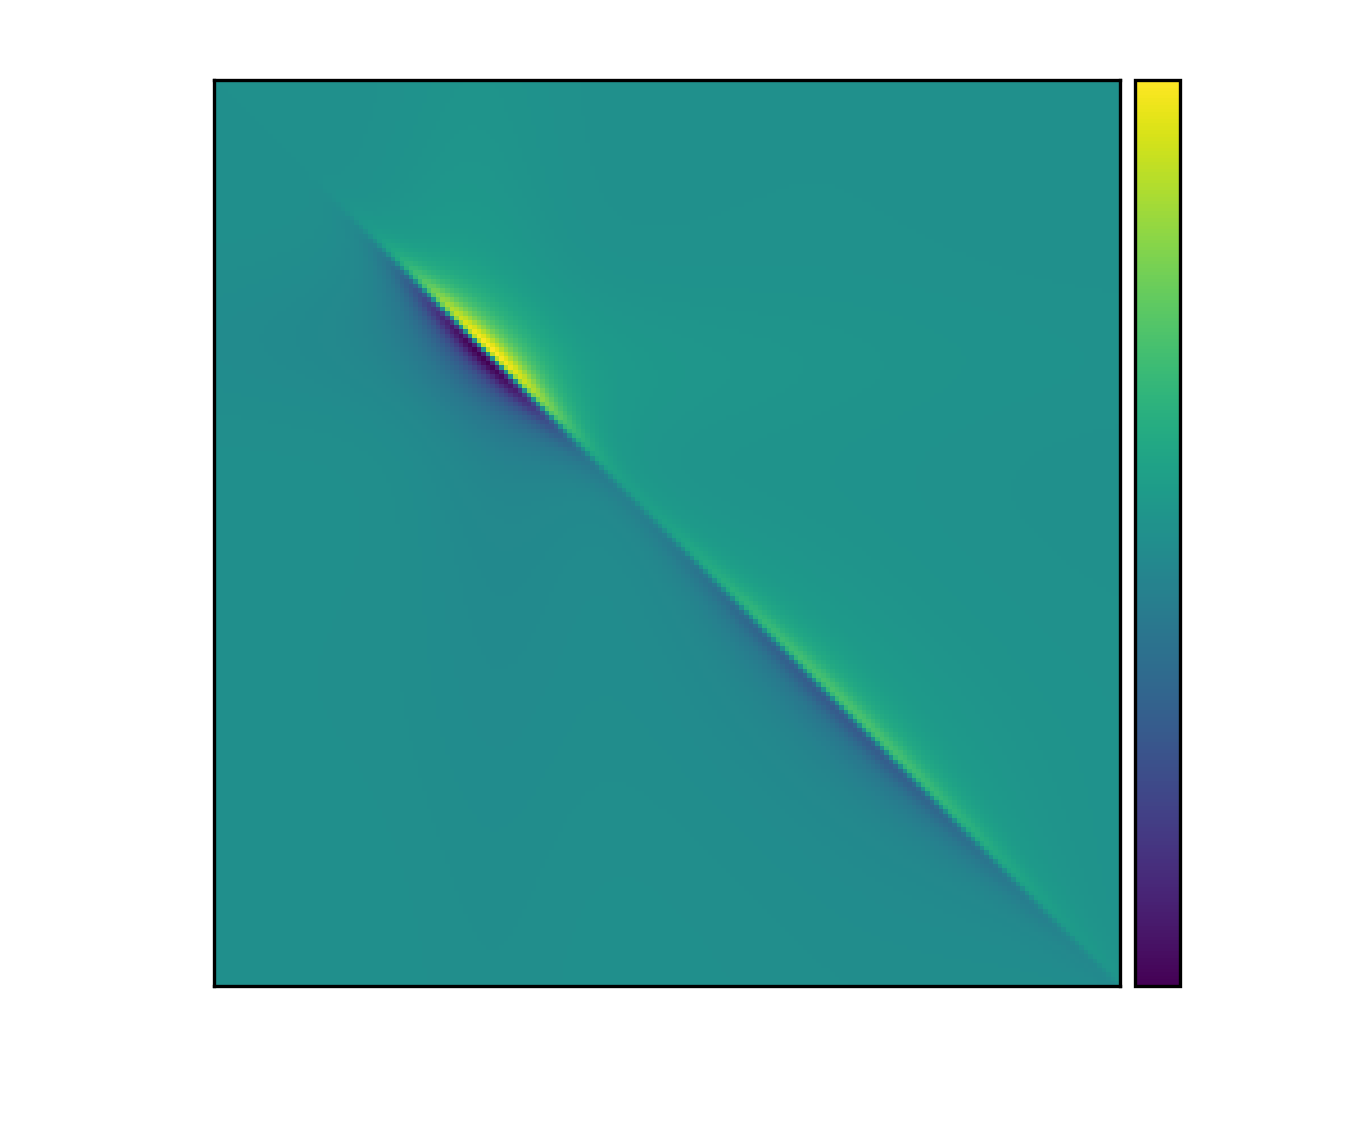

In [21]:
fig = plt.figure(dpi=300)
im = plt.imshow(I_tot_het.imag, origin='lower', extent=(min(omega_t / 2. / np.pi ), max(omega_t / 2. / np.pi ), min(omega_tau / 2. / np.pi ), max(omega_tau / 2. / np.pi )))
plt.xlabel(r'$\omega_t \quad [2 \pi] $', fontdict=font)
plt.ylabel(r'$\omega_\tau \quad [2 \pi] $', fontdict=font)
plt.xticks(**font)
plt.yticks(**font)
plt.title('Heterodyne detection sim.', fontdict=font)
colorbar(im, 'Amplitude (arb. units)')
plt.show()
# fig.savefig("/Users/tommychin/Documents/research/Smallwood_research/testVectorImage.eps", dpi=800, format='eps', bbox_inches='tight')

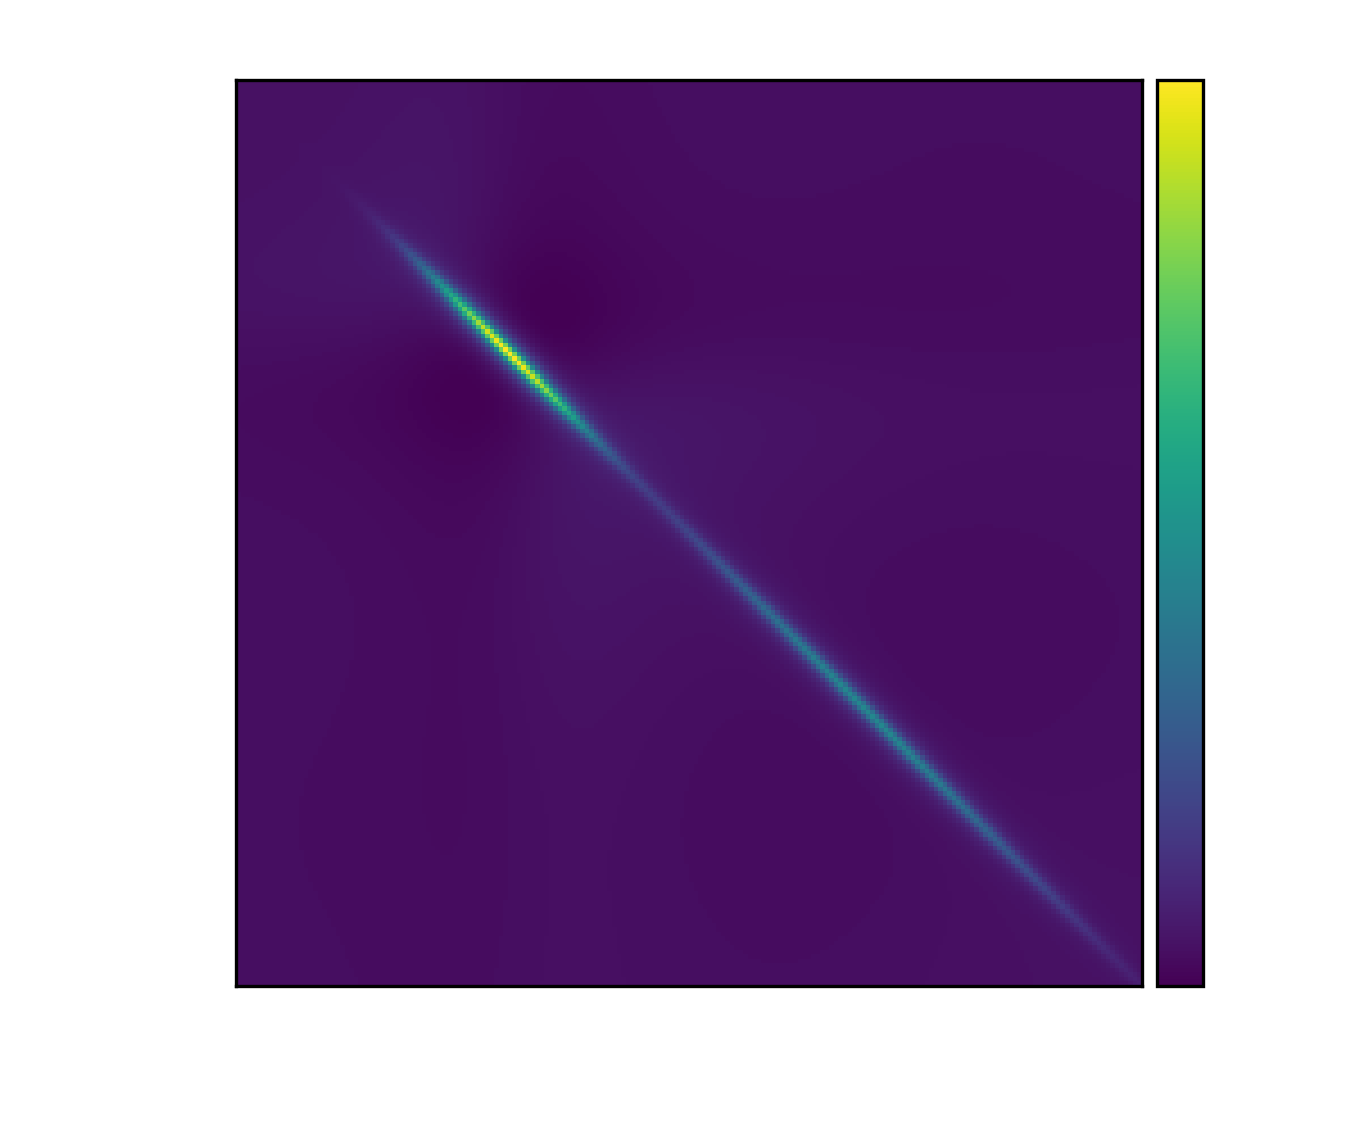

In [22]:
fig = plt.figure(dpi=300)
im = plt.imshow(I_tot_het.real, origin='lower', extent=(406.5, 407.1, -407.1, -406.5))
plt.xlabel(r'Third-order frequency, $\nu_t$, (THz)', fontdict=font)
plt.ylabel(r'First-order frequency, $\nu_\tau$, (THz)', fontdict=font)
plt.xticks(**font)
plt.yticks(**font)
plt.title('Heterodyne detection sim.', fontdict=font)
colorbar(im, 'Amplitude (arb. units)')
plt.show()
fig.savefig("/Users/tommychin/Documents/research/Smallwood_research/testVectorImage.eps", dpi=800, format='eps', bbox_inches='tight')

## Fig. S9(b)

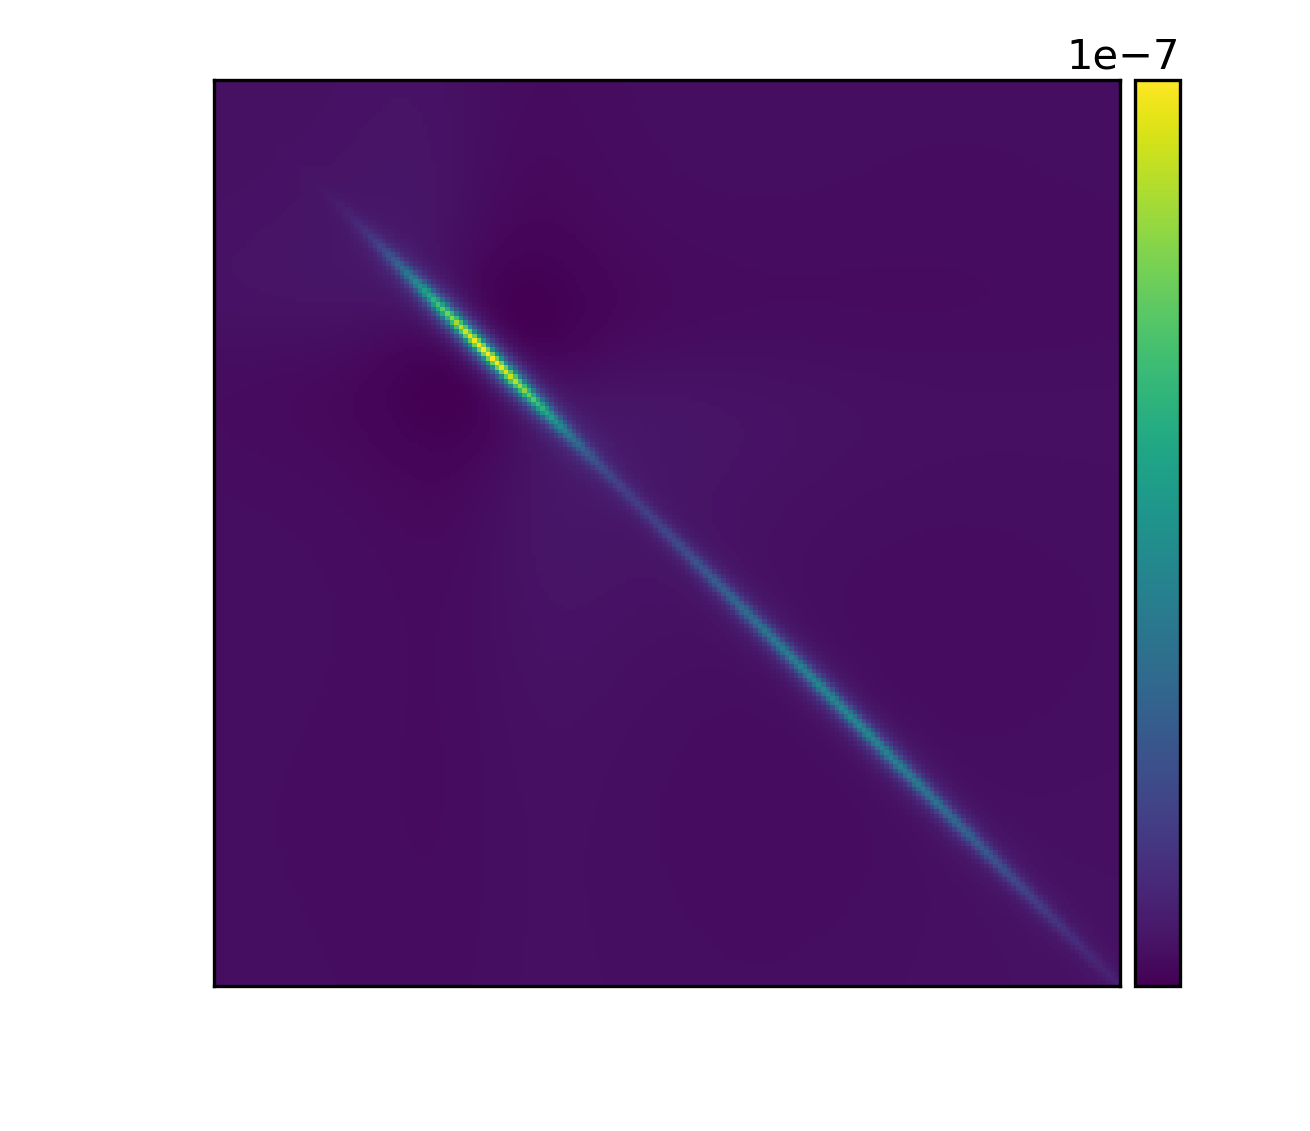

In [23]:
plt.figure(dpi=300)
im = plt.imshow(I_tot_PL.real, origin='lower', extent=(min(omega_t / 2. / np.pi ), max(omega_t / 2. / np.pi ), min(omega_tau / 2. / np.pi ), max(omega_tau / 2. / np.pi )))
plt.xlabel(r'$\omega_t \quad [2 \pi] $', fontdict=font)
plt.ylabel(r'$\omega_\tau \quad [2 \pi] $', fontdict=font)
plt.xticks(**font)
plt.yticks(**font)
plt.title('PL detection sim.', fontdict=font)
colorbar(im, 'Amplitude (arb. units)')
plt.show()